In [2]:
# !pip install -U eli5 transformers torch scikit-learn ipywidgets

import os, json, glob, math, itertools
from typing import List, Sequence, Dict, Callable, Optional
import numpy as np

import eli5
from eli5.lime import TextExplainer

from transformers import pipeline
from IPython.display import HTML, display

In [3]:
# Base directory where your result folders live
BASE_DIR = "/clwork/kexin/tsar_st/results"
# BASE_DIR = "/clwork/kexin/tsar_st/data/references" 
# BASE_DIR = "/clwork/kexin/tsar_st/data/input" 

# Set the model slug that varies (e.g., "claude_4", "gpt4o", etc.)
MODEL_SLUG = "gpt_5"

# The file inside each run directory
FILENAME = "simplifications.jsonl"
# FILENAME = "human_simplifications.jsonl"
# FILENAME = "documents.jsonl"

# Find candidate run directories that start with "<MODEL_SLUG>_target_..."
pattern = os.path.join(BASE_DIR, f"{MODEL_SLUG}_with_description_*", FILENAME)
# pattern = os.path.join(BASE_DIR, FILENAME)

candidates = sorted(glob.glob(pattern))

if not candidates:
    raise FileNotFoundError(f"No files found for pattern: {pattern}\n"
                            f"Check BASE_DIR and MODEL_SLUG, or list dirs under {BASE_DIR}")

# Pick the most recent by path sort (or choose an index manually)
TARGET_FILE = candidates[-1]
print("Using:", TARGET_FILE)


Using: /clwork/kexin/tsar_st/results/gpt_5_with_description_20250813-111658/simplifications.jsonl


In [4]:
def read_jsonl(path: str) -> List[dict]:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

rows = read_jsonl(TARGET_FILE)

# Extract just what we need for ELI5 local explanations
texts = []
text_ids = []
for r in rows:
    # Prefer 'simplified'; fall back to alternatives if format varies
    text = r.get("simplified") or r.get("original") or r.get("reference") or ""
    if not isinstance(text, str):
        text = str(text)
    texts.append(text)
    text_ids.append(r.get("text_id", f"idx-{len(text_ids)}"))

print(f"Loaded {len(texts)} texts.")
print("Example text_id & snippet:\n", text_ids[0], "->", texts[0][:160].replace("\n", " "), "...")

Loaded 40 texts.
Example text_id & snippet:
 01-a2 -> NASA is now trying to find and record smaller asteroids. These are 140 meters wide or bigger. Scientists think there are about 25,000 asteroids this size. So fa ...


In [5]:
# CEFR models you used in evaluation
CEFR_MODEL_NAMES = [
    "AbdullahBarayan/ModernBERT-base-doc_en-Cefr",
    "AbdullahBarayan/ModernBERT-base-doc_sent_en-Cefr",
    "AbdullahBarayan/ModernBERT-base-reference_AllLang-Cefr",
]

# Preferred canonical order for CEFR classes
CEFR_LABELS = ["A1", "A2", "B1", "B2", "C1", "C2"]

# Choose device automatically: GPU if available else CPU
# transformers pipelines accept device as int (>=0 cuda index, -1 CPU)
import torch
DEVICE = 0 if torch.cuda.is_available() else -1
DEVICE

0

In [6]:
# Build pipelines
cefr_pipes = []
for name in CEFR_MODEL_NAMES:
    p = pipeline(
        task="text-classification",
        model=name,
        device=DEVICE
    )
    cefr_pipes.append(p)

# Map each pipeline's native label order to CEFR_LABELS (for stable columns)
def get_order_map(p):
    # many models expose an id2label like {0:'A1', 1:'A2', ...}
    id2label = getattr(p.model.config, "id2label", None)
    if id2label:
        order = [id2label[i] for i in sorted(id2label)]
    else:
        # fallback: probe with a dummy input to read labels
        example = ["test"]
        out = p(example, return_all_scores=True, truncation=True)[0]
        order = [d["label"] for d in out]
    # build indices aligned to CEFR_LABELS
    order_upper = [lbl.upper() for lbl in order]
    idx_map = [order_upper.index(lbl) for lbl in CEFR_LABELS]
    return idx_map, order

ORDER_MAPS = []
for p in cefr_pipes:
    idx_map, order_seen = get_order_map(p)
    ORDER_MAPS.append(idx_map)
    print("Pipeline:", p.model.name_or_path)
    print("  model labels:", order_seen)
    print("  mapped order:", CEFR_LABELS)

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Pipeline: AbdullahBarayan/ModernBERT-base-doc_en-Cefr
  model labels: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
  mapped order: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
Pipeline: AbdullahBarayan/ModernBERT-base-doc_sent_en-Cefr
  model labels: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
  mapped order: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
Pipeline: AbdullahBarayan/ModernBERT-base-reference_AllLang-Cefr
  model labels: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
  mapped order: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']


In [7]:
def probs_from_pipeline(p, texts: Sequence[str], idx_map: List[int]) -> np.ndarray:
    """
    Returns probs as (N, 6) aligned to CEFR_LABELS using idx_map.
    """
    outputs = p(list(texts), return_all_scores=True, truncation=True)
    # outputs is a list of lists of dicts: [[{'label':..,'score':..}, ...], ...]
    arr = np.array([[d["score"] for d in out] for out in outputs], dtype=float)
    # reorder to CEFR_LABELS
    arr = arr[:, idx_map]
    return arr

def make_ensemble_predict_proba(pipes, order_maps) -> Callable[[Sequence[str]], np.ndarray]:
    def _predict_proba(batch_texts: Sequence[str]) -> np.ndarray:
        mats = [probs_from_pipeline(p, batch_texts, idx)
                for p, idx in zip(pipes, order_maps)]
        # average the probabilities across models
        avg = np.mean(np.stack(mats, axis=0), axis=0)
        # safety: renormalize to sum=1 per row (softmax-like)
        sums = np.clip(avg.sum(axis=1, keepdims=True), 1e-12, None)
        avg = avg / sums
        return avg
    return _predict_proba

predict_proba = make_ensemble_predict_proba(cefr_pipes, ORDER_MAPS)

# # Quick sanity check on a few items
# probs = predict_proba(texts[:3])
# print("Shape:", probs.shape)        # (3, 6)
# print("Row sums:", probs.sum(axis=1))  # ~1.0
# list(zip(CEFR_LABELS, probs[0].round(3)))

/clwork/kexin/tsar_st/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/clwork/kexin/tsar_st/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


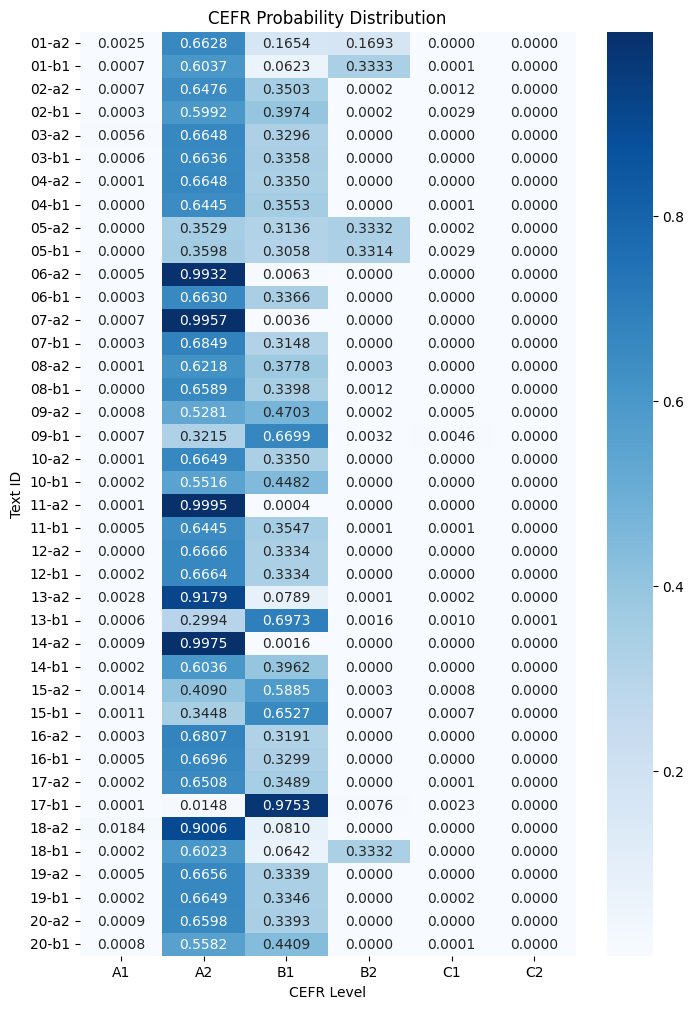

In [8]:
sel_idx = list(range(0, 40))  # every 2nd up to 40
sel_texts = [texts[i] for i in sel_idx]
sel_ids = [text_ids[i] for i in sel_idx]

probs = predict_proba(sel_texts)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 12))
sns.heatmap(probs, annot=True, fmt=".4f", cmap="Blues",
            xticklabels=CEFR_LABELS, yticklabels=sel_ids)
plt.xlabel("CEFR Level")
plt.ylabel("Text ID")
plt.title("CEFR Probability Distribution")
plt.show()

In [9]:
# separately predict using 3 models
def make_multi_model_predict_proba(pipes, order_maps):
    """
    Returns a function that outputs a list of probability arrays,
    one per model, each aligned to CEFR_LABELS.
    """
    def _predict_proba(batch_texts):
        mats = [probs_from_pipeline(p, batch_texts, idx)
                for p, idx in zip(pipes, order_maps)]
        return mats  # list of (N, 6) arrays
    return _predict_proba

# Build the new function
predict_proba_all = make_multi_model_predict_proba(cefr_pipes, ORDER_MAPS)

# # Example: get 3 separate outputs for the first 3 texts
# probs_list = predict_proba_all(texts[:3])

# for model_name, probs in zip(CEFR_MODEL_NAMES, probs_list):
#     print(f"\nModel: {model_name}")
#     print("Shape:", probs.shape)
#     print("Row sums:", probs.sum(axis=1))  # should be ~1.0
#     print("First row:", list(zip(CEFR_LABELS, probs[0].round(3))))

/clwork/kexin/tsar_st/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


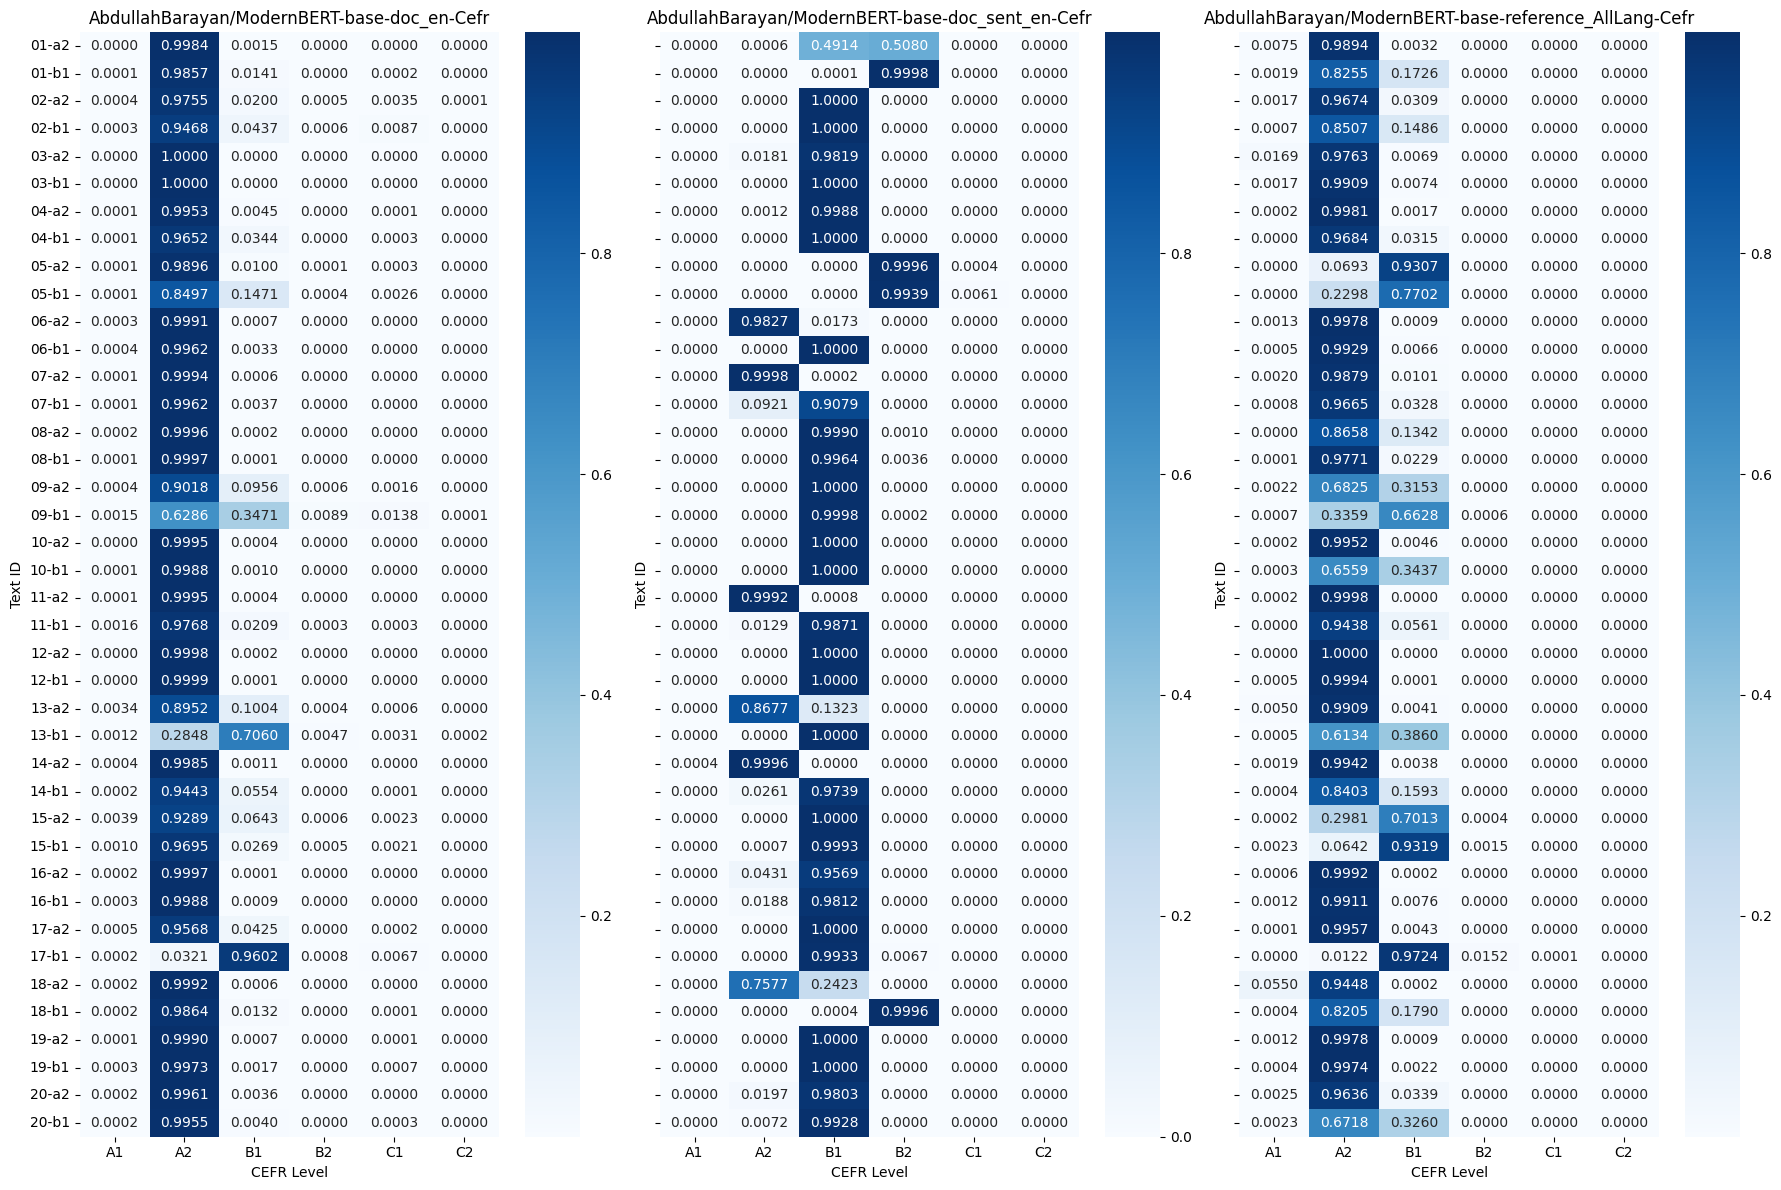

In [10]:
sel_idx = list(range(0, 40))  # every 2nd up to 40
sel_texts = [texts[i] for i in sel_idx]
sel_ids = [text_ids[i] for i in sel_idx]

# Get separate probabilities for each model
probs_list = predict_proba_all(sel_texts)

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(probs_list), figsize=(6 * len(probs_list), 12), sharey=True)

if len(probs_list) == 1:
    axes = [axes]  # make iterable if only one plot

for ax, model_name, probs in zip(axes, CEFR_MODEL_NAMES, probs_list):
    sns.heatmap(probs, annot=True, fmt=".4f", cmap="Blues",
                xticklabels=CEFR_LABELS, yticklabels=sel_ids, ax=ax)
    ax.set_xlabel("CEFR Level")
    ax.set_ylabel("Text ID")
    ax.set_title(model_name)

plt.tight_layout()
plt.show()

In [ ]:
# # Pick which text to explain
# i = 0    # change this index to explore other texts
# text = texts[i]
# print(text_ids[i], "-> length:", len(text))

# # More samples => more stable explanations; increase for production
# te = TextExplainer(random_state=42, n_samples=800)  

# te.fit(text, predict_proba=predict_proba)   # model-agnostic
# exp = te.explain_prediction()

# # Pretty HTML view inline
# display(HTML(eli5.format_as_html(exp)))

01-a2 -> length: 411
